# Latent Semantic Analysis (LSA)
* LSA is a technique used to identify **patterns in the relationships between terms and concepts** in large text corpora. 
* It reduces the dimensionality of the document-term matrix through **Singular Value Decomposition (SVD)**.
* Captures **underlying meanings and relationships** between words.

## Applications
* **Information Retrieval**
* **Recommender Systems**
* **Document Classification**

In [98]:
import spacy
import gensim
from gensim import corpora, models
from gensim.models import LsiModel
from sklearn.manifold import TSNE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
tqdm.pandas()


In [99]:
# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

## Load Data

In [100]:
df = pd.read_csv("/kaggle/input/bbc-news-rss-feeds/bbc_news.csv")
df.head()

,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,"Mon, 07 Mar 2022 08:01:56 GMT",https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,"Sun, 06 Mar 2022 22:49:58 GMT",https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',"Mon, 07 Mar 2022 00:14:42 GMT",https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,"Mon, 07 Mar 2022 00:05:40 GMT",https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,"Mon, 07 Mar 2022 08:15:53 GMT",https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...


In [101]:
df.columns.tolist()

['title', 'pubDate', 'guid', 'link', 'description']

In [102]:
df.drop(columns=['title', 'pubDate', 'guid', 'link'], inplace=True)
df.head()

,description
0,The Ukrainian president says the country will ...
1,"Jeremy Bowen was on the frontline in Irpin, as..."
2,One of the world's biggest fertiliser firms sa...
3,The parents of the Manchester Arena bombing's ...
4,Consumers are feeling the impact of higher ene...


In [103]:
df.rename(columns={'description': 'text'}, inplace=True)
df.head()

,text
0,The Ukrainian president says the country will ...
1,"Jeremy Bowen was on the frontline in Irpin, as..."
2,One of the world's biggest fertiliser firms sa...
3,The parents of the Manchester Arena bombing's ...
4,Consumers are feeling the impact of higher ene...


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39562 entries, 0 to 39561
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    39562 non-null  object
dtypes: object(1)
memory usage: 309.2+ KB


In [105]:
df_sub = df.sample(n=10_000, random_state=42).reset_index().drop(columns=['index'])
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


## Data Preprocessing

In [106]:
df_sub['text'][0]

'The larger-than-life actor excelled in comic and tougher roles, but also battled drink problems.'

In [107]:
nlp(df_sub['text'][0])

The larger-than-life actor excelled in comic and tougher roles, but also battled drink problems.

In [108]:
tokens = [token.lemma_ for token in nlp(df_sub['text'][0]) if not token.is_stop and not token.is_punct]
print(tokens)

['large', 'life', 'actor', 'excel', 'comic', 'tough', 'role', 'battle', 'drink', 'problem']


In [109]:
def preprocess(documents):
    spacy_doc = nlp(documents)
    tokens = [token.lemma_.lower() for token in spacy_doc if not token.is_stop and not token.is_punct]
    return tokens

In [110]:
df_sub['tokens'] = df_sub['text'].progress_apply(preprocess)
df_sub.head()

100%|██████████| 10000/10000 [01:45<00:00, 94.35it/s]


,text,tokens
0,The larger-than-life actor excelled in comic a...,"[large, life, actor, excel, comic, tough, role..."
1,Railway workers have voted to go on strike ove...,"[railway, worker, vote, strike, pay, job]"
2,A source close to the home secretary says she ...,"[source, close, home, secretary, say, demand, ..."
3,Newcastle and Italy midfielder Sandro Tonali i...,"[newcastle, italy, midfielder, sandro, tonali,..."
4,Moves by allies of Boris Johnson to stop Rishi...,"[move, ally, boris, johnson, stop, rishi, suna..."


In [112]:
# Create a dictionary and corpus
dictionary = corpora.Dictionary(df_sub['tokens'].tolist())
print(f'Dictionary Size before filtering: {len(dictionary.token2id)}')

dictionary.filter_extremes(no_below=2, no_above=0.95)
print(f'Dictionary Size after filtering: {len(dictionary.token2id)}')
print(f'Top 20 words in dictionary: \n{list(dictionary.token2id.items())[:20]}')

corpus = [dictionary.doc2bow(text) for text in df_sub['tokens'].tolist()]

Dictionary Size before filtering: 13878
Dictionary Size after filtering: 7175
Top 20 words in dictionary: 
[('actor', 0), ('battle', 1), ('comic', 2), ('drink', 3), ('large', 4), ('life', 5), ('problem', 6), ('role', 7), ('tough', 8), ('job', 9), ('pay', 10), ('railway', 11), ('strike', 12), ('vote', 13), ('worker', 14), ('close', 15), ('demand', 16), ('explanation', 17), ('home', 18), ('lancashire', 19)]


In [113]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [114]:
corpus_tfidf

## LSA Model

In [115]:
pip install --upgrade scipy gensim

  Using cached scipy-1.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Note: you may need to restart the kernel to use updated packages.


In [116]:
num_topics = 5

lsi_model = LsiModel(corpus_tfidf, num_topics=num_topics, id2word=dictionary)

In [117]:
lsi_topics = lsi_model.print_topics(num_words=5)
for idx, topic in lsi_topics:
    print(f"Topic {idx+1}: {topic}")

Topic 1: -0.217*"say" + -0.185*"year" + -0.180*"day" + -0.178*"england" + -0.175*"world"
Topic 2: -0.390*"past" + -0.387*"seven" + -0.371*"day" + -0.339*"closely" + -0.337*"attention"
Topic 3: -0.280*"cup" + -0.266*"final" + -0.239*"world" + 0.188*"people" + -0.183*"england"
Topic 4: -0.547*"year" + -0.338*"old" + 0.246*"minister" + 0.209*"election" + 0.183*"prime"
Topic 5: 0.385*"ukraine" + 0.256*"russia" + -0.231*"rise" + -0.189*"rate" + 0.184*"russian"


In [118]:
lsi_corpus = lsi_model[corpus_tfidf]
doc_topic_matrix = gensim.matutils.corpus2dense(lsi_corpus, num_terms=num_topics).T
doc_topic_matrix.shape

(10000, 5)

In [119]:
doc_topic_matrix.shape

(10000, 5)

## LSA Visualizations

### Word-Topic Distribution

In [120]:
lsi_model.show_topic(0)

[('say', -0.21738231001343702),
 ('year', -0.18546761545539447),
 ('day', -0.17960780843094865),
 ('england', -0.17760425002911004),
 ('world', -0.17532213737127333),
 ('final', -0.14731607879472203),
 ('cup', -0.14691008195491795),
 ('bbc', -0.1426876964349372),
 ('win', -0.1335704228170486),
 ('people', -0.13060748123456828)]

In [121]:
def word_topic_distribution(lsi_model, num_words=10, title='Word-Topic Distribution'):
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 10), sharex=False)
    axes = axes.flatten()
    
    topics = lsi_model.print_topics()
    
    words = []
    weights = []
    for topic in topics:
        words.append([word for word, _ in lsi_model.show_topic(topic[0], topn=num_words)])
        weights.append([weight for _, weight in lsi_model.show_topic(topic[0], topn=num_words)])
        
        ax = axes[topic[0]]
        ax.barh(words[topic[0]], weights[topic[0]], height=0.7)
        ax.set_title(f'Topic {topic[0]+1}', fontdict={'fontsize': 10})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)

#     topic_idx = 0
#     plt.figure(figsize=(10, 5))
#     plt.barh(words[topic_idx], weights[topic_idx], color='skyblue')
#     plt.xlabel('Weight')
#     plt.title(f'Topic {topic_idx}')
#     plt.show()
    
    fig.suptitle(title, fontsize=14)
    plt.subplots_adjust(top=0.90, hspace=0.3, wspace=0.5)
    plt.show()

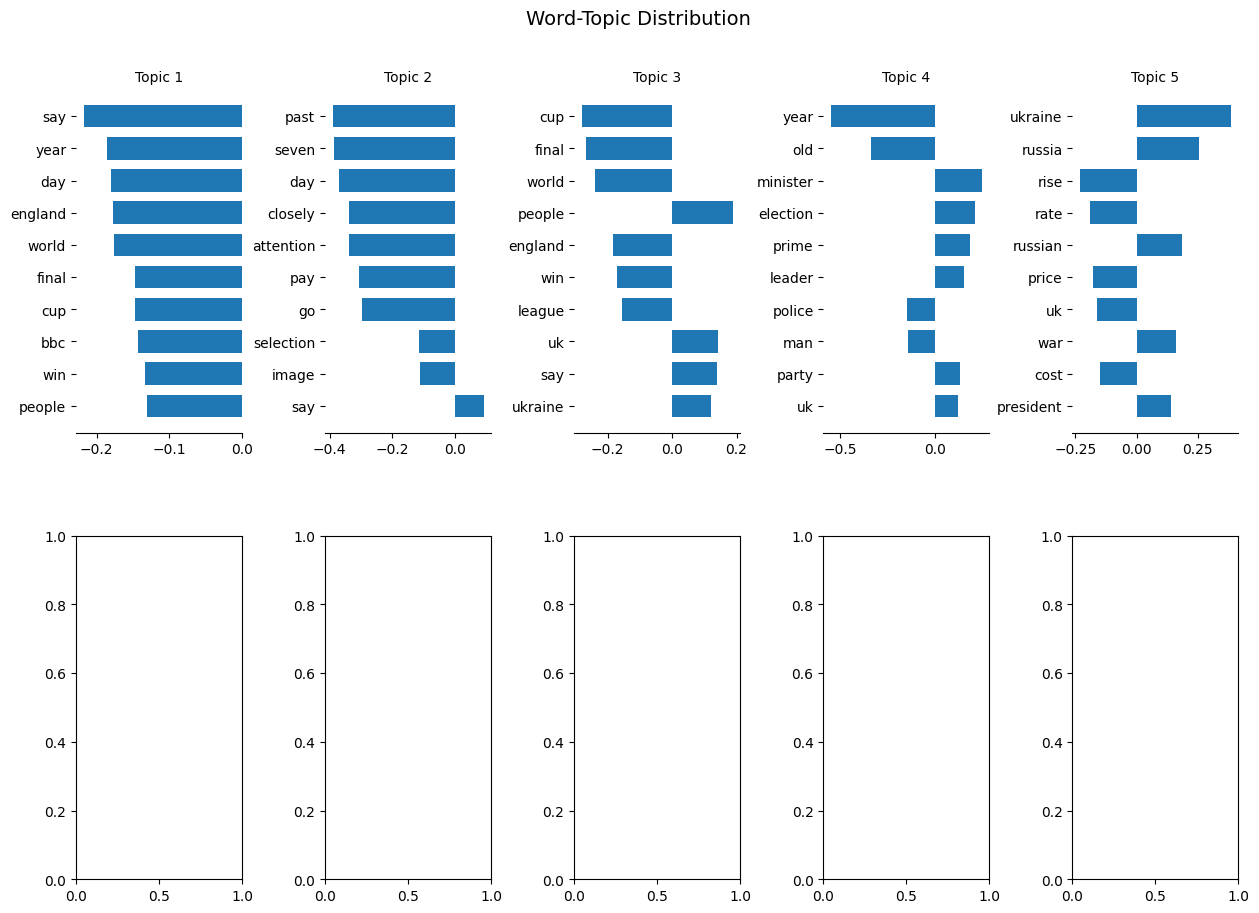

In [122]:
word_topic_distribution(lsi_model)

### 2D Projection of Document Vectors

In [124]:
def get_limited_words_to_plot(words, num_words_to_plot=1000):
    
    if len(words) > num_words_to_plot:
        indices = np.random.choice(len(words), num_words_to_plot, replace=False)
    else:
        indices = np.arange(len(words))
        
    limited_word_vectors = word_vectors[indices]
    limited_words = [words[i] for i in indices]
    
    return limited_word_vectors, limited_words

In [125]:
word_vectors = lsi_model.get_topics().T
words = list(dictionary.values())

print(f'Word Vectors Shape: {word_vectors.shape}')
print(f'Vocabulary: {len(words)}')

word_vectors_lim, words_lim = get_limited_words_to_plot(words)

print(f'Limited Word Vectors Shape: {word_vectors_lim.shape}')
print(f'Limited Vocabulary: {len(words_lim)}')

Word Vectors Shape: (7175, 5)
Vocabulary: 7175
Limited Word Vectors Shape: (1000, 5)
Limited Vocabulary: 1000


In [126]:
tsne = TSNE(n_components=2, random_state=42)
word_embeddings_2d = tsne.fit_transform(word_vectors_lim)
print(f'Word Vectors 2d shape: {word_embeddings_2d.shape}')

Word Vectors 2d shape: (1000, 2)


In [127]:
def show_word_clusters(words, word_embeddings_2d):
    plt.figure(figsize=(12, 10))
    plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1], alpha=0.3)

    for i, word in enumerate(words):
        plt.annotate(word, xy=(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1]), fontsize=10)

    plt.title('Word Clusters in LSA Space (t-SNE)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid()
    plt.show()


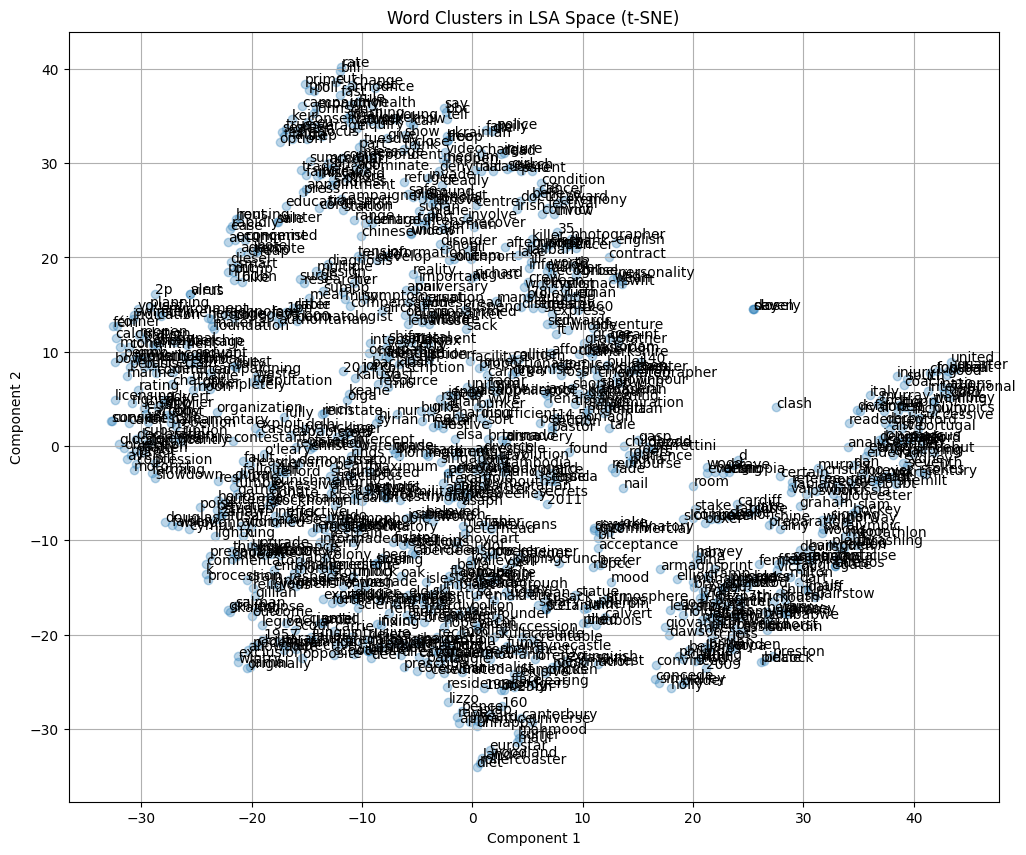

In [128]:
show_word_clusters(words_lim, word_embeddings_2d)

### Topic Correlation Matrix

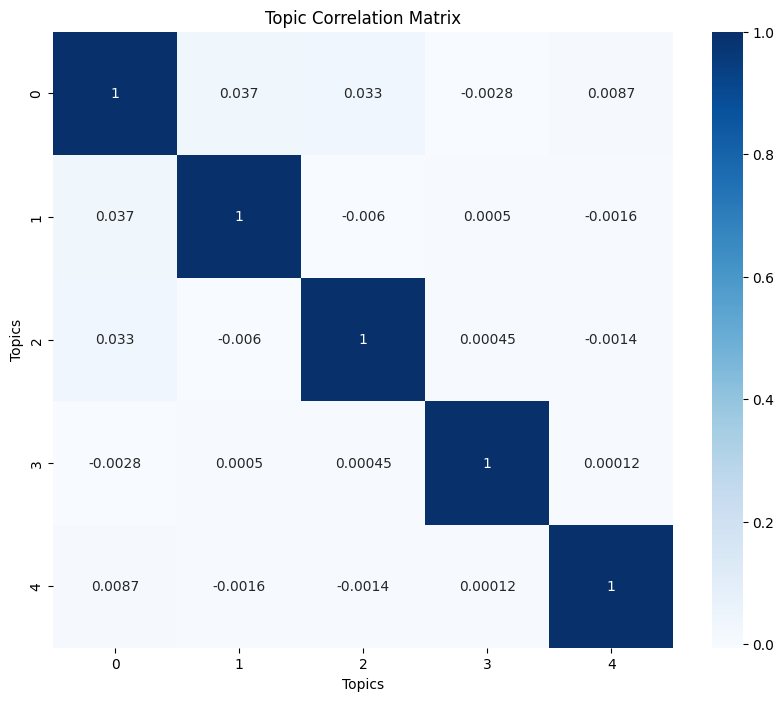

In [129]:
topic_term_matrix = lsi_model.get_topics()

corr_matrix = np.corrcoef(topic_term_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='Blues', annot=True)
plt.title('Topic Correlation Matrix')
plt.xlabel('Topics')
plt.ylabel('Topics')
plt.show()
